# 1. Overview & Objectives
## Time Series Forecasting - Top Models Visualization

This notebook trains the best model of each family (Baseline, Statistical, ML, Neural) and visualizes:  
1. Full time series of actual data (1980-Nov 2025).
2. Validation period with actual data and model forecasts.
3. Test period with actual data and model forecasts.
4. Forecast period with actual data till the cutoff date and predictions of the best model.

# 2. Imports & Setup

In [23]:
import import_ipynb
import sys
sys.path.append("code")

from splitting import split_time_series
from metrics import load_best_models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [25]:
#MLForecast
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.lag_transforms import RollingMean, RollingStd

#Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

#NeuralForecast
from neuralforecast import NeuralForecast
from neuralforecast.models import GRU
from neuralforecast.losses.pytorch import MAE

#Torch (for reproducibility)
import torch
torch.manual_seed(42)

c:\Public\TIS3IL-WS25-Project\.venv\Lib\site-packages\neuralforecast\losses\pytorch.py:114: SyntaxWarning: invalid escape sequence '\m'
  $$ \mathrm{MAE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} |y_{\\tau} - \hat{y}_{\\tau}| $$
c:\Public\TIS3IL-WS25-Project\.venv\Lib\site-packages\neuralforecast\losses\pytorch.py:155: SyntaxWarning: invalid escape sequence '\m'
  $$ \mathrm{MSE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} (y_{\\tau} - \hat{y}_{\\tau})^{2} $$
c:\Public\TIS3IL-WS25-Project\.venv\Lib\site-packages\neuralforecast\losses\pytorch.py:198: SyntaxWarning: invalid escape sequence '\m'
  $$ \mathrm{RMSE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\sqrt{\\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} (y_{\\tau} - \hat{y}_{\\tau})^{2}} $$
c:\Public\TIS3IL-WS25-Project\.venv\Lib\site-packages\neuralforecast\losses\pytorch.py:242: SyntaxWarning: invalid escape sequence '\m'
  $$ \mathrm{MAPE}(\\math

# 3. Load Data & Train/Val/Test Split

In [26]:
splits = split_time_series(
    csv_path="../data/processed/processed_weather_data_michigan.csv",
    date_col="time",
    y_col="tavg",
    train_end="2015-12-31",
    val_end="2020-12-31",
    test_end="2025-11-30",
    start_date="1980-01-01",
    end_date="2025-11-30"
)

train_df = splits["train"]
val_df   = splits["val"]
test_df  = splits["test"]

h_val  = len(val_df)
h_test = len(test_df)

# 4. Training the best Models

## 4.1 Baseline Model (Best: Seasonal Naïve)

In [27]:
def seasonal_naive_forecast(train_df, horizon, season_length=365):
    seasonal_tail = train_df["tavg"].iloc[-season_length:]
    repeats = int(np.ceil(horizon / season_length))
    return np.tile(seasonal_tail.values, repeats)[:horizon]

##### Training + Forecasting wrapper + Run

In [29]:
def run_baseline_seasonal_naive(train_df, val_df, test_df, season_length=365):
    h_val  = len(val_df)
    h_test = len(test_df)

    #Validation forecast
    val_pred = seasonal_naive_forecast(
        train_df,
        h_val,
        season_length=season_length
    )

    #Test forecast (retrain on train + val)
    extended_train = pd.concat([train_df, val_df], ignore_index=True)
    test_pred = seasonal_naive_forecast(
        extended_train,
        h_test,
        season_length=season_length
    )

    return {
        "model_family": "Baseline",
        "model_name": "Seasonal Naive",
        "params": {"season_length": season_length},
        "val_pred": val_pred,
        "test_pred": test_pred
    }

#Running the baseline seasonal naive model
baseline_results = run_baseline_seasonal_naive(train_df, val_df, test_df, season_length=365)

## 4.2 Statistical Model (Best: Holt-Winters)

In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def train_holt_winters(train_df, season_length=365):
    model = ExponentialSmoothing(
        train_df["tavg"],
        trend="add",
        seasonal="add",
        seasonal_periods=season_length
    )
    return model.fit(optimized=True)

##### Training + Forecasting wrapper + Run

In [33]:
def run_statistical_holt_winters(train_df, val_df, test_df, season_length=365):
    h_val  = len(val_df)
    h_test = len(test_df)

    # Train on train
    model = train_holt_winters(train_df, season_length)

    # Validation forecast
    val_pred = model.forecast(h_val)

    # Retrain on train + val
    extended_train = pd.concat([train_df, val_df], ignore_index=True)
    model_extended = train_holt_winters(extended_train, season_length)

    # Test forecast
    test_pred = model_extended.forecast(h_test)

    return {
        "model_family": "Statistical",
        "model_name": "Holt-Winters",
        "params": {"season_length": season_length},
        "val_pred": val_pred.values,
        "test_pred": test_pred.values
    }

#Running the Holt-Winters model
stat_results = run_statistical_holt_winters(train_df, val_df, test_df, season_length=365)

c:\Public\TIS3IL-WS25-Project\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Public\TIS3IL-WS25-Project\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


## 4.3 ML Model (Best: MLP via MLForecast)

##### Lags

In [34]:
LAGS = list(range(1, 30)) + [60, 91, 182, 365]

##### Best ML model definition

In [35]:
from sklearn.neural_network import MLPRegressor

mlp_best = {
    "MLP_h20_mi500": MLPRegressor(
        hidden_layer_sizes=(20,),
        max_iter=500,
        random_state=42
    )
}

In [36]:
from mlforecast import MLForecast

ml_fcst = MLForecast(
    models=mlp_best,
    freq="D",
    lags=LAGS,
    target_transforms=None
)

##### Training + Forecasting Wrapper + Run

In [38]:
def run_ml_mlp_forecast(train_df, val_df, test_df):
    TARGET_COL = "tavg"

    #MLForecast requires a unique_id
    train_temp = train_df.copy()
    train_temp["unique_id"] = "station_1"

    #Fit on training data
    ml_fcst.fit(
        train_temp,
        id_col="unique_id",
        time_col="time",
        target_col=TARGET_COL
    )

    #Validation forecast
    H_VAL = len(val_df)
    val_preds = ml_fcst.predict(H_VAL)

    val_pred = val_preds["MLP_h20_mi500"].values

    #Test forecast
    #IMPORTANT: retrain on train + val
    extended_train = pd.concat([train_df, val_df], ignore_index=True)
    extended_train["unique_id"] = "station_1"

    ml_fcst.fit(
        extended_train,
        id_col="unique_id",
        time_col="time",
        target_col=TARGET_COL
    )

    H_TEST = len(test_df)
    test_preds = ml_fcst.predict(H_TEST)

    test_pred = test_preds["MLP_h20_mi500"].values

    return {
        "model_family": "ML",
        "model_name": "MLP_h20_mi500",
        "params": {
            "hidden_layer_sizes": (20,),
            "max_iter": 500,
            "random_state": 42,
            "lags": LAGS
        },
        "val_pred": val_pred,
        "test_pred": test_pred
    }

#Running the MLForecast MLP model
ml_results = run_ml_mlp_forecast(train_df, val_df, test_df)

## 4.4 Neural Model (Best: GRU – NeuralForecast)

In [40]:
def to_nixtla_format(df, uid="series_1"):
    out = df.rename(columns={"time": "ds", "tavg": "y"}).copy()
    out["unique_id"] = uid
    return out[["unique_id", "ds", "y"]]

##### Training + Forecasting Wrapper + Run

In [42]:
from neuralforecast import NeuralForecast
from neuralforecast.models import GRU
from neuralforecast.losses.pytorch import MAE

def run_neural_gru_forecast(train_df, val_df, test_df):
    #Convert data
    train_nf = to_nixtla_format(train_df)
    val_nf   = to_nixtla_format(val_df)
    test_nf  = to_nixtla_format(test_df)

    INPUT_SIZE = 365
    MAX_STEPS  = 500

    #Validation
    H_VAL = len(val_nf)

    gru_val = GRU(
        h=H_VAL,
        input_size=INPUT_SIZE,
        encoder_hidden_size=64,
        encoder_n_layers=2,
        decoder_hidden_size=64,
        decoder_layers=2,
        loss=MAE(),
        max_steps=MAX_STEPS
    )

    nf_val = NeuralForecast(
        models=[gru_val],
        freq="D"
    )

    nf_val.fit(train_nf)
    val_forecast = nf_val.predict()

    val_pred = val_forecast.iloc[:, 2].values  # GRU output

    #Test
    H_TEST = len(test_nf)

    gru_test = GRU(
        h=H_TEST,
        input_size=INPUT_SIZE,
        encoder_hidden_size=64,
        encoder_n_layers=2,
        decoder_hidden_size=64,
        decoder_layers=2,
        loss=MAE(),
        max_steps=MAX_STEPS
    )

    nf_test = NeuralForecast(
        models=[gru_test],
        freq="D"
    )

    train_val_nf = pd.concat([train_nf, val_nf])
    nf_test.fit(train_val_nf)

    test_forecast = nf_test.predict()
    test_pred = test_forecast.iloc[:, 2].values

    return {
        "model_family": "Neural",
        "model_name": "GRU",
        "params": {
            "input_size": INPUT_SIZE,
            "encoder_hidden_size": 64,
            "encoder_n_layers": 2,
            "decoder_hidden_size": 64,
            "decoder_layers": 2,
            "loss": "MAE",
            "max_steps": MAX_STEPS
        },
        "val_pred": val_pred,
        "test_pred": test_pred
    }

#Running the NeuralForecast GRU model
neural_results = run_neural_gru_forecast(train_df, val_df, test_df)

Seed set to 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name              | Type          | Params | Mode 
------------------------------------------------------------
0 | loss              | MAE           | 0      | train
1 | padder_train      | ConstantPad1d | 0      | train
2 | scaler            | TemporalNorm  | 0      | train
3 | hist_encoder      | GRU           | 37.8 K | train
4 | mlp_decoder       | MLP           | 4.2 K  | train
5 | upsample_sequence | Linear        | 668 K  | train
------------------------------------------------------------
710 K     Trainable params
0         Non-trainable params
710 K     Total params
2.843     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name              | Type          | Params | Mode 
------------------------------------------------------------
0 | loss              | MAE           | 0      | train
1 | padder_train      | ConstantPad1d | 0      | train
2 | scaler            | TemporalNorm  | 0      | train
3 | hist_encoder      | GRU           | 37.8 K | train
4 | mlp_decoder       | MLP           | 4.2 K  | train
5 | upsample_sequence | Linear        | 655 K  | train
------------------------------------------------------------
697 K     Trainable params
0         Non-trainable params
697 K     Total params
2.792     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

In [69]:
all_models = [
    baseline_results,   # Seasonal Naive
    stat_results,       # Holt-Winters
    ml_results,         # MLP (MLForecast)
    neural_results      # GRU (NeuralForecast)
]

# 5. Plotting Functions

In [59]:
#Imports
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

#Setup
train_start = train_df['time'].min()
train_end = train_df['time'].max()
val_start = val_df['time'].min()
val_end = val_df['time'].max()
test_start = test_df['time'].min()
test_end = test_df['time'].max()

## 5.1 Actual Time Series Data with shaded Backround for Train/Val/Test Splits

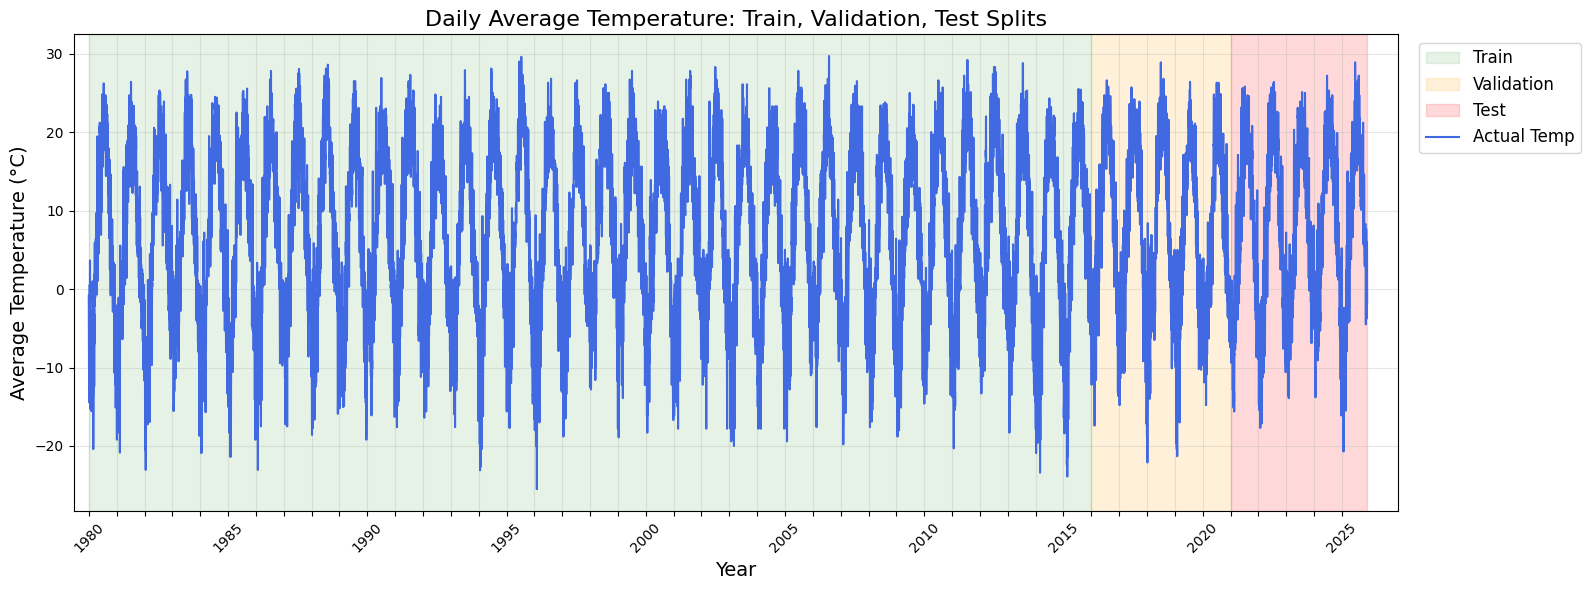

In [65]:
plt.figure(figsize=(16, 6))

#Background shading
plt.axvspan(train_start, train_end, color="green", alpha=0.1, label="Train")
plt.axvspan(val_start, val_end, color="orange", alpha=0.15, label="Validation")
plt.axvspan(test_start, test_end, color="red", alpha=0.15, label="Test")

#Plot actual data
plt.plot(train_df['time'], train_df['tavg'], color='royalblue')
plt.plot(val_df['time'], val_df['tavg'], color='royalblue')
plt.plot(test_df['time'], test_df['tavg'], color='royalblue',label='Actual Temp')

#X-axis ticks
years = pd.date_range(start=train_df['time'].min(), end=test_df['time'].max(), freq='YS')
plt.xticks(years)
labels = [year.year if year.year % 5 == 0 else '' for year in years]
plt.gca().set_xticklabels(labels)

#Add padding: start a little before the first date
start_pad = train_df['time'].min() - pd.Timedelta(days=200)
end_pad = test_df['time'].max() + pd.Timedelta(days=400)
plt.xlim(start_pad, end_pad)

#Labels and title
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Temperature (°C)", fontsize=14)
plt.title("Daily Average Temperature: Train, Validation, Test Splits", fontsize=16)

#Grid and legend
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

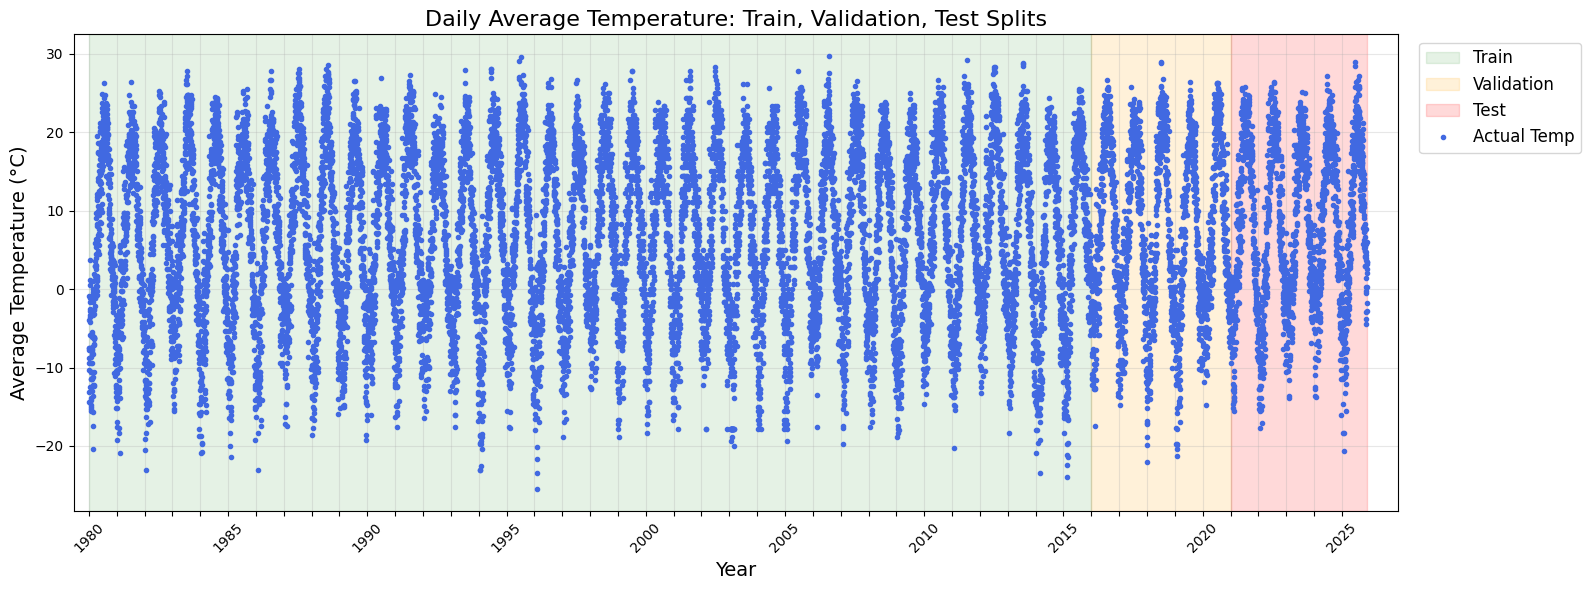

In [66]:
plt.figure(figsize=(16, 6))

#Background shading
plt.axvspan(train_start, train_end, color="green", alpha=0.1, label="Train")
plt.axvspan(val_start, val_end, color="orange", alpha=0.15, label="Validation")
plt.axvspan(test_start, test_end, color="red", alpha=0.15, label="Test")

#Plot actual data
plt.plot(train_df['time'], train_df['tavg'], 'o', color='royalblue', markersize=3)
plt.plot(val_df['time'], val_df['tavg'], 'o', color='royalblue', markersize=3)
plt.plot(test_df['time'], test_df['tavg'], 'o', color='royalblue', markersize=3, label='Actual Temp')

#X-axis ticks
years = pd.date_range(start=train_df['time'].min(), end=test_df['time'].max(), freq='YS')
plt.xticks(years)
labels = [year.year if year.year % 5 == 0 else '' for year in years]
plt.gca().set_xticklabels(labels)

#Add padding: start a little before the first date
start_pad = train_df['time'].min() - pd.Timedelta(days=200)
end_pad = test_df['time'].max() + pd.Timedelta(days=400)
plt.xlim(start_pad, end_pad)

#Labels and title
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Temperature (°C)", fontsize=14)
plt.title("Daily Average Temperature: Train, Validation, Test Splits", fontsize=16)

#Grid and legend
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5.2 Validation period with actual data and model forecasts

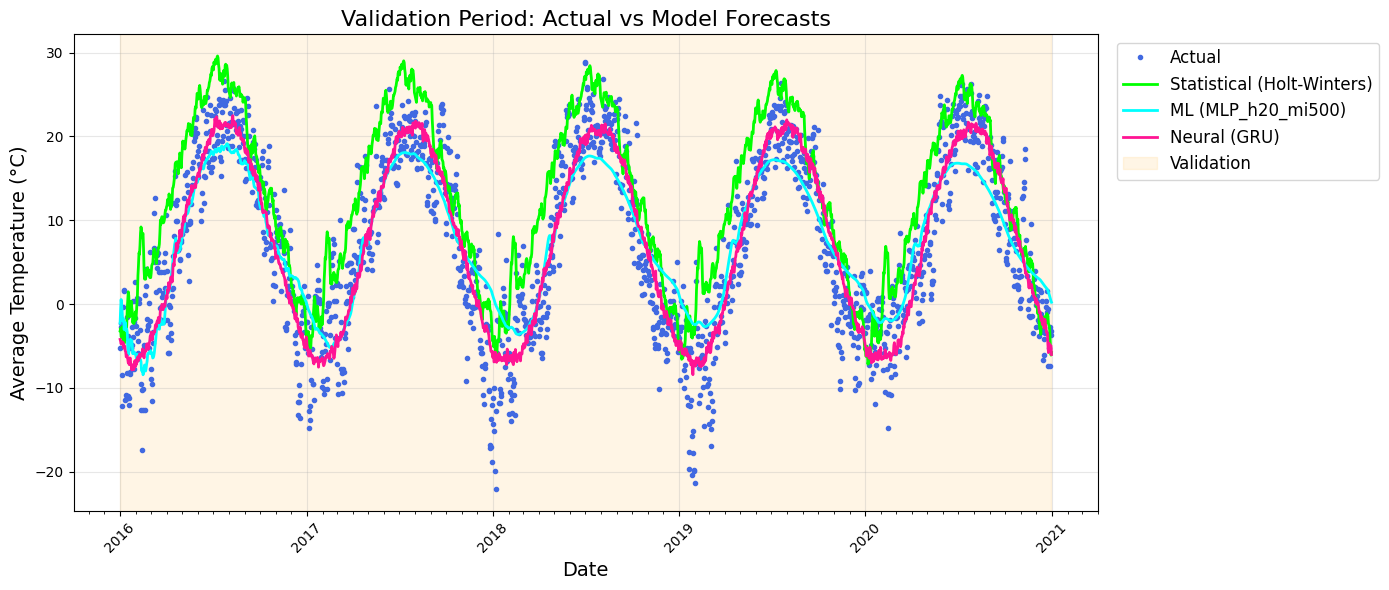

In [ ]:
plt.figure(figsize=(14, 6))

models_to_plot = all_models[1:] #skip the first element - Baseline

#Actual validation data
plt.plot(val_df['time'], val_df['tavg'], 'o', color='royalblue', markersize=3, label='Actual', linewidth=2)

#Plot each model's validation predictions
colors = ['lime', 'aqua', 'deeppink', 'lightblue']
for i, model in enumerate(models_to_plot):
    plt.plot(
        val_df['time'],
        model['val_pred'],
        '-', color=colors[i % len(colors)], linewidth=2,
        label=f"{model['model_family']} ({model['model_name']})"
    )

#Background shading
plt.axvspan(val_start, val_end, color="orange", alpha=0.1, label="Validation")

#Labels and title
plt.xlabel("Date", fontsize=14)
plt.ylabel("Average Temperature (°C)", fontsize=14)
plt.title("Validation Period: Actual vs Model Forecasts", fontsize=16)

#Grid and legend outside the plot
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=12)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.xticks(rotation=0)

#X-axis formatting: show only month/day
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

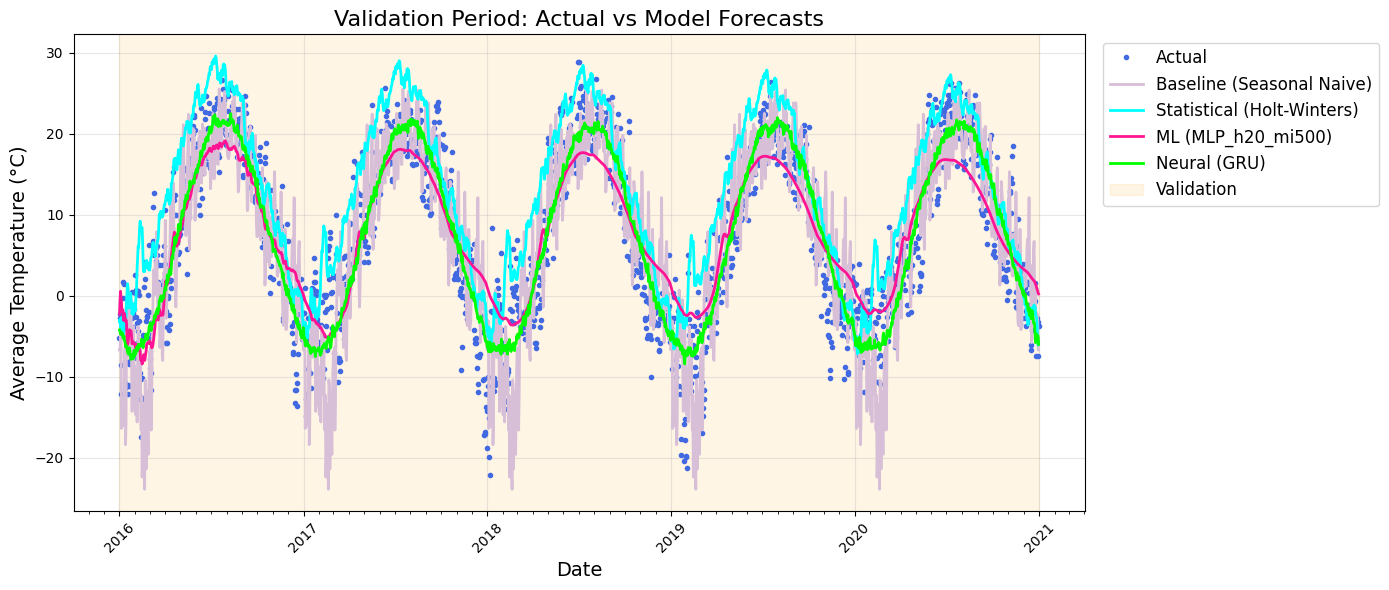

In [ ]:
plt.figure(figsize=(14, 6))

#Actual validation data
plt.plot(val_df['time'], val_df['tavg'], 'o', color='royalblue', markersize=3, label='Actual', linewidth=2)

#Plot each model's validation predictions
colors = ['thistle', 'aqua', 'deeppink', 'lime']
for i, model in enumerate(all_models):
    plt.plot(
        val_df['time'],
        model['val_pred'],
        '-', color=colors[i % len(colors)], linewidth=2,
        label=f"{model['model_family']} ({model['model_name']})"
    )

#Background shading
plt.axvspan(val_start, val_end, color="orange", alpha=0.1, label="Validation")

#Labels and title
plt.xlabel("Date", fontsize=14)
plt.ylabel("Average Temperature (°C)", fontsize=14)
plt.title("Validation Period: Actual vs Model Forecasts", fontsize=16)

#Grid and legend outside the plot
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=12)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.xticks(rotation=0)

#X-axis formatting: show only month/day
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5.3 Test period with actual data and model forecasts.

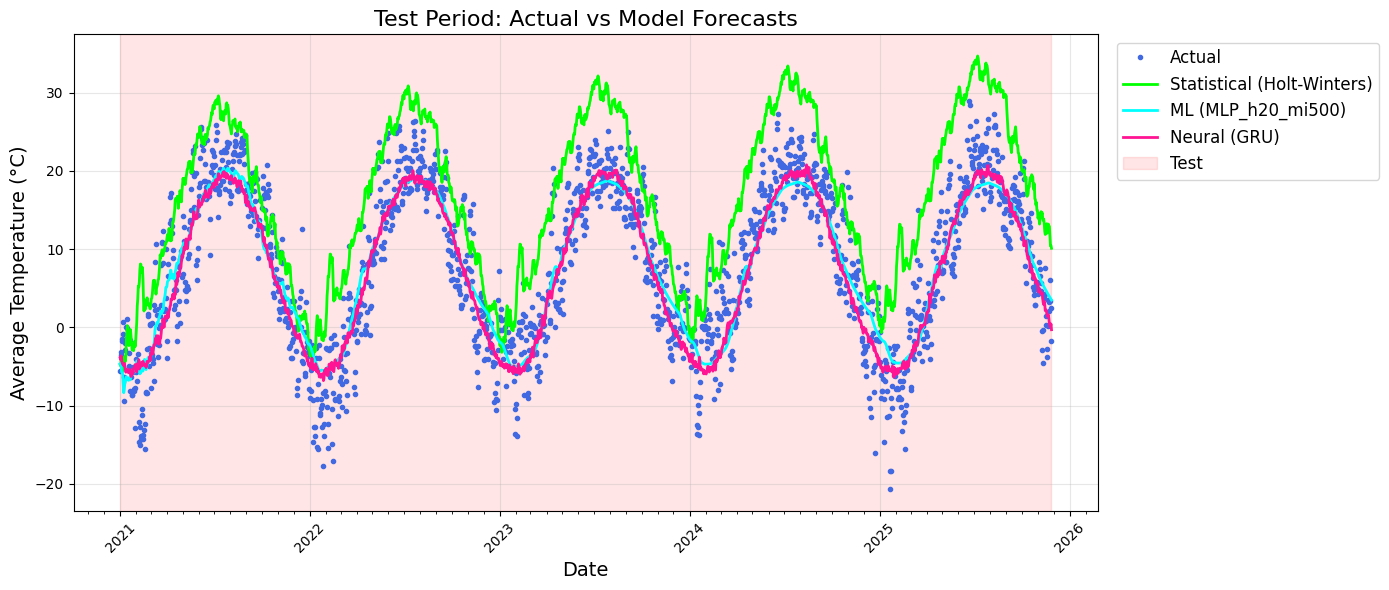

In [ ]:
plt.figure(figsize=(14, 6))

models_to_plot = all_models[1:] #skip baseline

#Actual test data
plt.plot(test_df['time'], test_df['tavg'], 'o', color='royalblue', markersize=3, label='Actual', linewidth=2)

#Plot each model's test predictions
colors = ['lime', 'aqua', 'deeppink', 'lightblue']
for i, model in enumerate(models_to_plot):
    plt.plot(
        test_df['time'],
        model['test_pred'],
        '-', color=colors[i % len(colors)], linewidth=2,
        label=f"{model['model_family']} ({model['model_name']})"
    )

#Background shading
plt.axvspan(test_start, test_end, color="red", alpha=0.1, label="Test")

#Labels and title
plt.xlabel("Date", fontsize=14)
plt.ylabel("Average Temperature (°C)", fontsize=14)
plt.title("Test Period: Actual vs Model Forecasts", fontsize=16)

#Grid and legend outside the plot
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=12)

#X-axis formatting
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

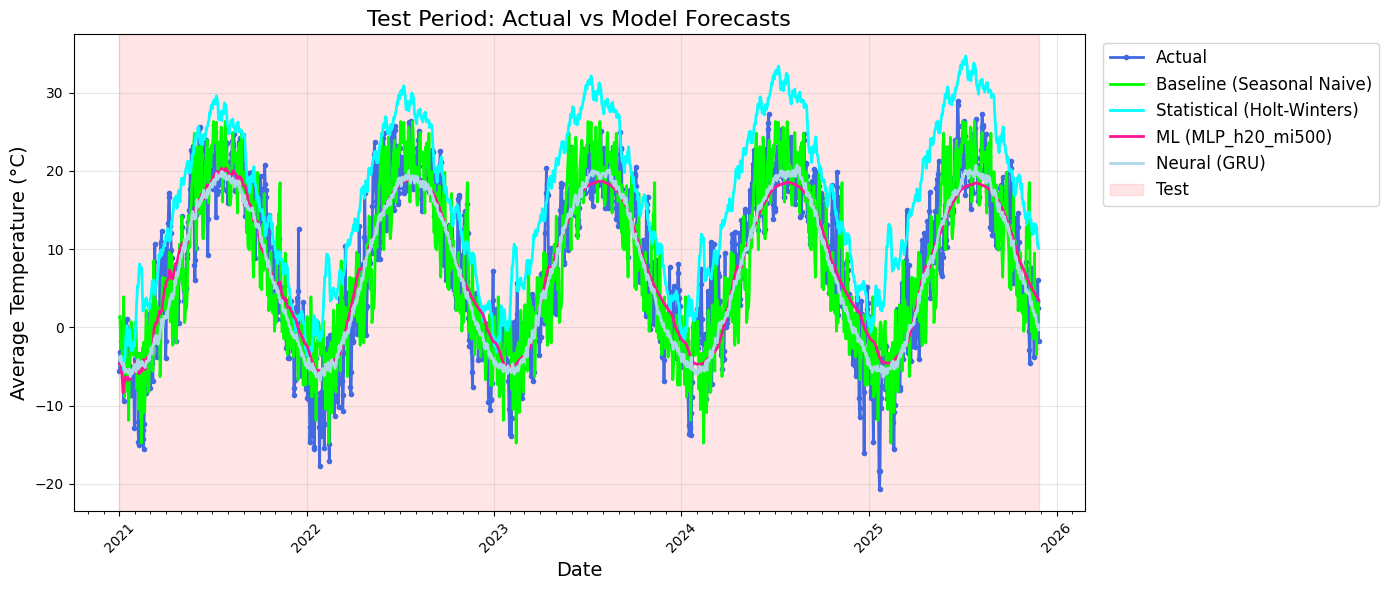

In [114]:
plt.figure(figsize=(14, 6))

#Actual test data
plt.plot(test_df['time'], test_df['tavg'], '-o', color='royalblue', markersize=3, label='Actual', linewidth=2)

#Plot each model's test predictions
colors = ['lime', 'aqua', 'deeppink', 'lightblue']
for i, model in enumerate(all_models):
    plt.plot(
        test_df['time'],
        model['test_pred'],
        '-', color=colors[i % len(colors)], linewidth=2,
        label=f"{model['model_family']} ({model['model_name']})"
    )

#Background shading
plt.axvspan(test_start, test_end, color="red", alpha=0.1, label="Test")

#Labels and title
plt.xlabel("Date", fontsize=14)
plt.ylabel("Average Temperature (°C)", fontsize=14)
plt.title("Test Period: Actual vs Model Forecasts", fontsize=16)

#Grid and legend outside the plot
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=12)

#X-axis formatting
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 5.4 Future Forecast for December and January

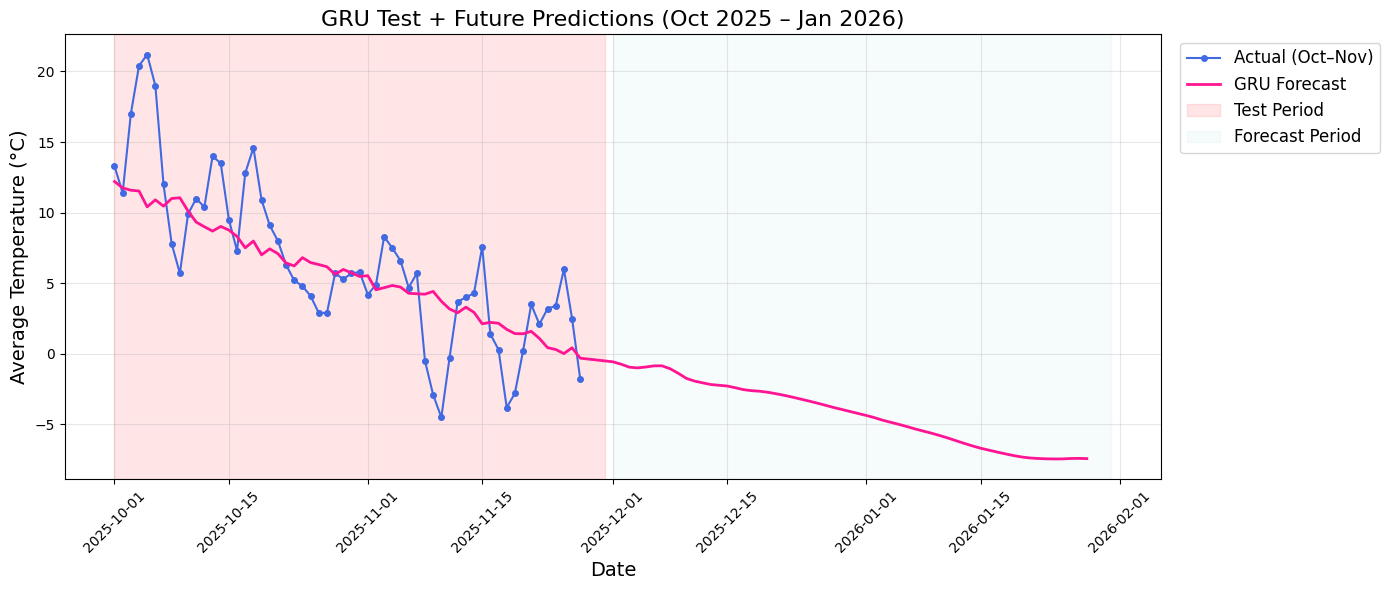

In [ ]:
#Load future predictions
future_pred = pd.read_parquet("../data/models/best_neural_forecast_dec_jan.parquet", engine="fastparquet")

#Filter actual test data for October–November
test_oct_nov = test_df[(test_df['time'] >= "2025-10-01") & (test_df['time'] <= "2025-11-30")]

#Example if column is 'index' instead of 'ds'
if 'date' in future_pred.columns:
    future_pred = future_pred.rename(columns={'date': 'ds'})

#Ensure it's datetime
future_pred['ds'] = pd.to_datetime(future_pred['ds'])


#Get corresponding GRU test predictions for Oct–Nov
test_pred_series = pd.Series(neural_results['test_pred'], index=test_df['time'])
test_pred_oct_nov = test_pred_series.loc["2025-10-01":"2025-11-30"]

#Combine test predictions with future predictions (Dec–Jan)
#Convert index to Series before concatenation
combined_dates = pd.concat([pd.Series(test_pred_oct_nov.index), future_pred['ds']])
combined_values = pd.concat([pd.Series(test_pred_oct_nov.values), future_pred['y_pred']])

#Plot
plt.figure(figsize=(14, 6))

#Actual data for Oct–Nov
plt.plot(test_oct_nov['time'], test_oct_nov['tavg'], '-o', color='royalblue', markersize=4, label='Actual (Oct–Nov)')

#GRU forecast (test + future)
plt.plot(combined_dates, combined_values, '-', color='deeppink', linewidth=2, label='GRU Forecast')

#highlight Oct–Nov and Dec–Jan periods
plt.axvspan("2025-10-01", "2025-11-30", color='red', alpha=0.1, label="Test Period")
plt.axvspan("2025-12-01", "2026-01-31", color='lightblue', alpha=0.1, label="Forecast Period")

#Labels, grid, and legend
plt.xlabel("Date", fontsize=14)
plt.ylabel("Average Temperature (°C)", fontsize=14)
plt.title("GRU Test + Future Predictions (Oct 2025 – Jan 2026)", fontsize=16)
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=12)

#X-axis formatting
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

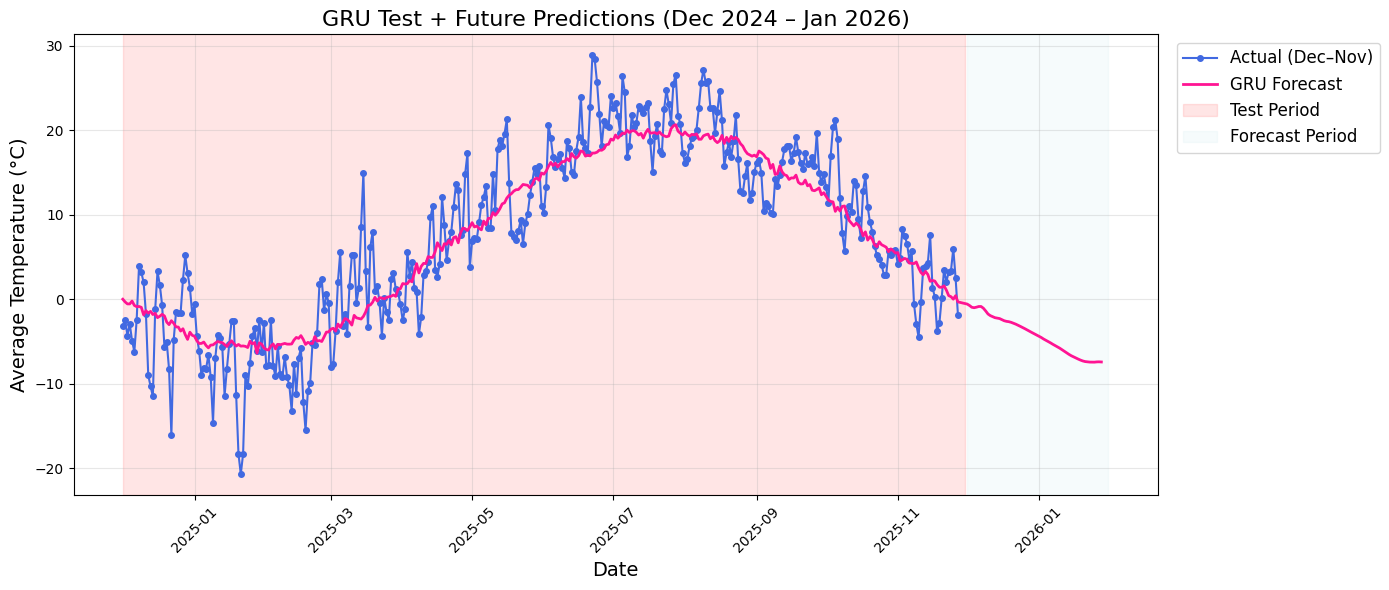

In [130]:
#Load future predictions
future_pred = pd.read_parquet("../data/models/best_neural_forecast_dec_jan.parquet", engine="fastparquet")

#Filter actual test data for December–November
test_oct_nov = test_df[(test_df['time'] >= "2024-12-01") & (test_df['time'] <= "2025-11-30")]

#Example if column is 'index' instead of 'ds'
if 'date' in future_pred.columns:
    future_pred = future_pred.rename(columns={'date': 'ds'})

#Ensure it's datetime
future_pred['ds'] = pd.to_datetime(future_pred['ds'])


#Get corresponding GRU test predictions for Dec–Nov
test_pred_series = pd.Series(neural_results['test_pred'], index=test_df['time'])
test_pred_oct_nov = test_pred_series.loc["2024-12-01":"2025-11-30"]

#Combine test predictions with future predictions (Dec–Jan)
#Convert index to Series before concatenation
combined_dates = pd.concat([pd.Series(test_pred_oct_nov.index), future_pred['ds']])
combined_values = pd.concat([pd.Series(test_pred_oct_nov.values), future_pred['y_pred']])


#Plot
plt.figure(figsize=(14, 6))

#Actual data for Dec–Nov
plt.plot(test_oct_nov['time'], test_oct_nov['tavg'], '-o', color='royalblue', markersize=4, label='Actual (Dec–Nov)')

#GRU forecast (test + future)
plt.plot(combined_dates, combined_values, '-', color='deeppink', linewidth=2, label='GRU Forecast')

#highlight Dec–Nov and Dec–Jan periods
plt.axvspan("2024-12-01", "2025-11-30", color='red', alpha=0.1, label="Test Period")
plt.axvspan("2025-12-01", "2026-01-31", color='lightblue', alpha=0.1, label="Forecast Period")

#Labels, grid, and legend
plt.xlabel("Date", fontsize=14)
plt.ylabel("Average Temperature (°C)", fontsize=14)
plt.title("GRU Test + Future Predictions (Dec 2024 – Jan 2026)", fontsize=16)
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=12)

#X-axis formatting
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()